In [145]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
import contextily as ctx
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))
from util.isochrones import Isochrones
from util.extract_urbancenter import ExtractCenters

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'))
cities.head(3)

,City,Country,ID_HDC_G0,city_name,country_id,city_id
0,Vienna,AUT,3027,Vienna,AUT,3027
1,Graz,AUT,3000,Graz,AUT,3000
2,Brussels,BEL,2135,Brussels,BEL,2135


# Aggregate all Pickles
Also make some initial data exploration. 

In [157]:
isochrones_list = []
for i, (pid, city) in enumerate(cities.iterrows()):
    
    
    isochrone_path = os.path.join(DROOT, '3-traveltime-cities', f'{city.city_id}.isochrones.pcl')
    if not os.path.exists(isochrone_path):
        continue;
    
    # Extract urban center and read in as pickle
    logging.info(f"=== Starting {city.city_name} ({city.city_id}) ===")
    
    isochrones = gpd.GeoDataFrame(pd.read_pickle(isochrone_path))
    isochrones['geometry'] = isochrones['geometry'].to_crs('EPSG:4326')
    isochrones.insert(4, 'trmode_type', isochrones.trmode.str.replace('_off', '').str.replace('_peak', ''))
    
    isochrones_list.append(isochrones)

isochrones = pd.concat(isochrones_list)
isochrones = isochrones.merge(cities[['city_name', 'city_id']])
isochrones.sample(2)

INFO:root:=== Starting Vienna (3027) ===
INFO:root:=== Starting Graz (3000) ===
INFO:root:=== Starting Brussels (2135) ===
INFO:root:=== Starting Berlin (2851) ===
INFO:root:=== Starting Hamburg (2531) ===
INFO:root:=== Starting Copenhagen (2749) ===
INFO:root:=== Starting Aarhus (2518) ===
INFO:root:=== Starting Paris (2046) ===
INFO:root:=== Starting Marseille (2228) ===
INFO:root:=== Starting Birmingham (1800) ===
INFO:root:=== Starting York (1874) ===
INFO:root:=== Starting Luxembourg (2253) ===
INFO:root:=== Starting Amsterdam (2167) ===
INFO:root:=== Starting Utrecht (2181) ===
INFO:root:=== Starting Stockholm (2973) ===
INFO:root:=== Starting Gothenburg (2682) ===


,uid,pid,startpt,trmode,trmode_type,tt_mnts,dep_dt,source,city_id,isochrone,cell_pop,geometry,reach_n,reach_km2,reach_pop,reach_geo,city_name
20082,2046-940-transit_off-15m-g,940,POINT (2.62225 48.82145),transit_off,transit,15,2023-06-13 13:30:37+02:00,g,2046,"MULTIPOLYGON (((2.61541 48.82147, 2.61541 48.8...",1233.816040,"POLYGON ((2.61593 48.82618, 2.61562 48.81672, ...",5.0,5000000.0,5948.025085,"POLYGON ((2.602978386686228 48.82617997990587,...",Paris
4012,2135-203-cycling-15m-g,203,POINT (4.36589 50.81451),cycling,cycling,15,2023-06-13 08:30:00+02:00,g,2135,"POLYGON ((4.40975 50.80936, 4.41402 50.80688, ...",7704.759277,"POLYGON ((4.35953 50.81932, 4.35896 50.80971, ...",58.0,58000000.0,525819.586090,"POLYGON ((4.317968695667884 50.79048841223568,...",Brussels


In [158]:
# Average amount of squares of 1km2 reached per mode. More is better. 
isochrones.pivot_table(values='reach_n', columns='trmode', index='city_name', aggfunc=['mean', 'std']).sort_values(('mean', 'cycling'))

mean                                                     
trmode        cycling driving_off driving_peak transit_off transit_peak   
city_name                                                                 
Vienna      29.196429   44.665816    44.665816   10.882653    11.183673  \
Marseille   30.521569   52.450980    52.188235    5.560784     5.560784   
Gothenburg  36.354839   80.456989    80.456989         NaN          NaN   
Amsterdam   38.371014   77.846377    77.846377         NaN          NaN   
Luxembourg  39.833333   67.142857    73.976190         NaN          NaN   
Stockholm   40.822715   53.606648    49.808864         NaN          NaN   
Hamburg     42.356455   59.976879    59.911368    7.421965     7.423892   
Berlin      42.537901   56.871720    59.007289   12.782799    12.897959   
Paris       43.012821   64.138584    72.933455    7.669719     7.669719   
Birmingham  43.095808  105.443114   111.000000         NaN          NaN   
York        43.750000  107.725000   107.725000         NaN          NaN   
Utrecht     43.790323   85.354839    77.443548         NaN          NaN   
Aarhus      44.493976   62.578313    63.674699   10.216867    10.819277   
Graz        45.178082   48.123288    47.657534    7.739726     7.739726   
Copenhagen  45.884021   89.432990    83.103093   11.536082    11.327320   
Brussels    47.984962   67.214286    58.048872   11.191729    11.609023   

                            std                                        
trmode       walking    cycling driving_off driving_peak transit_off   
city_name                                                              
Vienna      5.420918  21.442833   35.229798    35.229798    5.279551  \
Marseille   5.941176  14.695550   26.655364    26.152111    2.541628   
Gothenburg  7.215054  11.601160   29.550704    29.550704         NaN   
Amsterdam   7.220290   9.240726   24.673381    24.673381         NaN   
Luxembourg  7.714286   8.051410   22.635577    24.975586         NaN   
Stockholm   7.623269  11.458216   23.104001    22.212222         NaN   
Hamburg     7.772640  11.266948   18.621703    19.408329    2.034732   
Berlin      8.266764   9.374956   17.387751    18.091130    6.749386   
Paris       7.987179   9.829354   20.721995    22.501201    1.532446   
Birmingham  8.022455   8.202631   29.051855    31.578702         NaN   
York        8.025000   6.632283   45.061774    45.061774         NaN   
Utrecht     7.790323   7.021771   22.815696    24.058297         NaN   
Aarhus      7.783133   9.968699   19.964066    19.377576    4.342215   
Graz        7.904110   6.423357   12.514375    12.720521    1.142942   
Copenhagen  7.835052  11.046037   33.931123    33.454272    6.797646   
Brussels    8.180451   8.633402   27.632138    22.642785    4.210150   

                                   
trmode     transit_peak   walking  
city_name                          
Vienna         5.876124  3.858610  
Marseille      2.541628  2.714874  
Gothenburg          NaN  2.132627  
Amsterdam           NaN  1.902613  
Luxembourg          NaN  1.088425  
Stockholm           NaN  1.804904  
Hamburg        2.035754  1.728241  
Berlin         6.912261  1.234647  
Paris          1.532446  1.407010  
Birmingham          NaN  1.252681  
York                NaN  0.973692  
Utrecht             NaN  1.339058  
Aarhus         4.798741  1.615838  
Graz           1.142942  1.144606  
Copenhagen     6.785650  1.657684  
Brussels       4.759633  1.218317

# Take a single city example

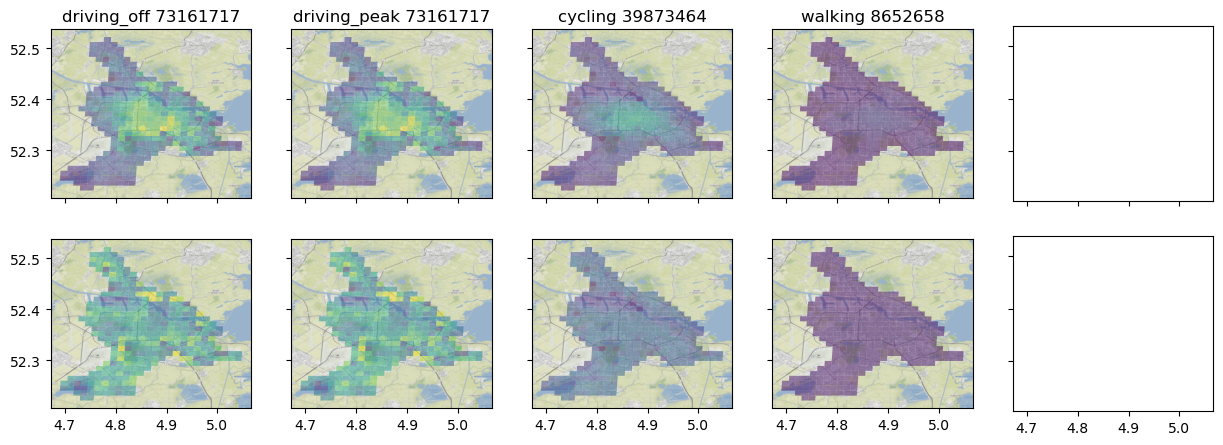

In [163]:
isochrones_ams = isochrones[isochrones.city_name == 'Amsterdam']
fig, axs = plt.subplots(ncols=6, nrows=2, sharex=True, sharey=True, figsize=(15,5))
for i, trmode in enumerate(isochrones_ams.trmode.unique()):
    isochrone = isochrones_ams[isochrones_ams.trmode==trmode]
    axs[0,i].set_title(f'{trmode} {isochrone.reach_pop.sum():.0f}')
    isochrone.plot(column='reach_pop', ax=axs[0,i], alpha=0.5, vmin=isochrones_ams.reach_pop.min(), vmax=isochrones_ams.reach_pop.max(), legend=i==4)
    isochrone.plot(column='reach_km2', ax=axs[1,i], alpha=0.5, vmin=isochrones_ams.reach_km2.min(), vmax=isochrones_ams.reach_km2.max(), legend=i==4)
    ctx.add_basemap(ax=axs[0,i], crs=isochrone.crs, attribution="")
    ctx.add_basemap(ax=axs[1,i], crs=isochrone.crs, attribution="")


trmode_type
driving    600
cycling     84
transit      2
Name: count, dtype: int64

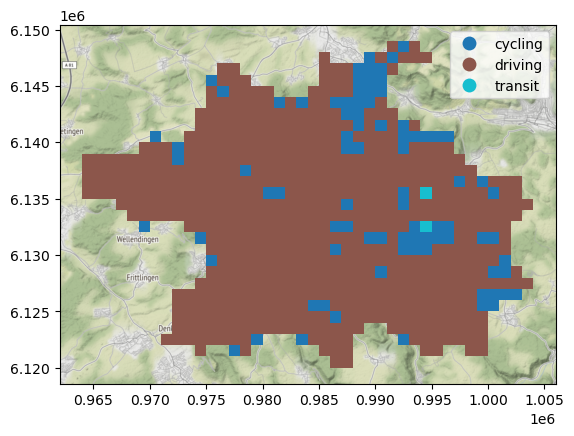

In [97]:
fig, ax = plt.subplots()
fastest_mode = isochrones.groupby('pid').apply(lambda x: x.loc[x.reach_pop.idxmax()])
fastest_mode.plot(column='trmode_type', ax=ax, legend=True)
ctx.add_basemap(ax=ax, crs=fastest_mode.crs, attribution="")

fastest_mode.trmode_type.value_counts()

,cycling,driving_off,driving_peak,transit_off,transit_peak,walking,geometry,cyc_carpeak,pt_carpeak,cyc_carpeak_bool,pt_carpeak_bool,carpeak_fastest_bool
pid,,,,,,,,,,,,
0,58726.708206,80868.737919,79308.320179,7298.696129,18538.020439,7298.696129,"POLYGON ((331000.000 5973000.000, 331000.000 5...",0.740486,0.233746,False,False,True
1,53762.300110,100903.527729,93241.288319,5900.257751,16793.553650,5900.257751,"POLYGON ((332000.000 5973000.000, 332000.000 5...",0.576593,0.180109,False,False,True


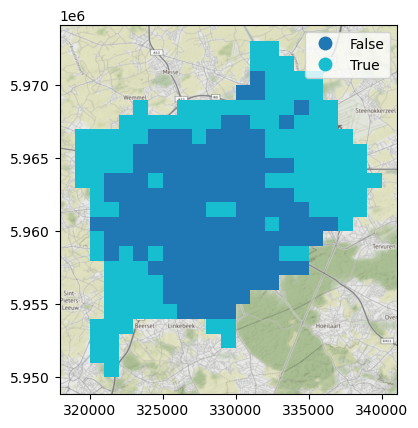

In [90]:
pivot_df = isochrones.pivot_table(index='pid', columns='trmode', values='reach_pop')
pivot_df = pivot_df.merge(isochrones[['pid', 'geometry']].drop_duplicates(), on='pid', how='left')
pivot_df = gpd.GeoDataFrame(pivot_df, crs=isochrones.crs)
pivot_df = pivot_df.set_index('pid', drop=True)

pivot_df['cyc_carpeak'] = pivot_df.cycling / pivot_df.driving_peak
pivot_df['pt_carpeak'] = pivot_df.transit_peak / pivot_df.driving_peak

fig, ax = plt.subplots()
pivot_df['cyc_carh_bool'] = pivot_df.cyc_carpeak > 1
pivot_df['pt_carh_bool'] = pivot_df.cyc_carpeak > 1
pivot_df['carh_bool'] = ~pivot_df[['cyc_carpeak_bool', 'pt_carpeak_bool']].any(axis=1)
pivot_df.plot(column='carpeak_fastest_bool', ax=ax, legend=True)
ctx.add_basemap(ax=ax, crs=pivot_df.crs, attribution="")

pivot_df_clean = pivot_df[pivot_df.cyc_carpeak < pivot_df['cyc_carpeak'].quantile(0.999)]
pivot_df_clean.plot(column='carpeak_fastest_bool', ax=ax, legend=True)

pivot_df.head(2)

,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cell_pop,geometry,reach_n,reach_km2,reach_pop,reach_geo
902,3027-150-driving_off-10m-g,150,POINT (16.34180 48.21704),driving_off,10,2023-06-13 08:30:00+02:00,g,3027,"POLYGON ((16.29163 48.23442, 16.29203 48.23672...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",79.0,79000000.0,675798.422028,"POLYGON ((16.29021 48.18406, 16.27736 48.18406..."
903,3027-150-driving_peak-10m-g,150,POINT (16.34180 48.21704),driving_peak,10,2023-06-13 08:30:00+02:00,g,3027,"POLYGON ((16.29163 48.23442, 16.29203 48.23672...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",79.0,79000000.0,675798.422028,"POLYGON ((16.29021 48.18406, 16.27736 48.18406..."
904,3027-150-cycling-15m-g,150,POINT (16.34180 48.21704),cycling,15,2023-06-13 08:30:00+02:00,g,3027,"POLYGON ((16.30188 48.23116, 16.29922 48.23319...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",61.0,61000000.0,583617.385742,"POLYGON ((16.30494 48.19348, 16.29209 48.19348..."
905,3027-150-walking-15m-g,150,POINT (16.34180 48.21704),walking,15,2023-06-13 08:30:00+02:00,g,3027,"POLYGON ((16.35493 48.21778, 16.35141 48.22420...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",9.0,9000000.0,101720.812500,"POLYGON ((16.32157 48.21233, 16.32346 48.22175..."
900,3027-150-transit_off-15m-g,150,POINT (16.34180 48.21704),transit_off,15,2023-06-13 13:30:37+02:00,g,3027,"POLYGON ((16.34157 48.21645, 16.34157 48.21645...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",1.0,1000000.0,10681.670898,"POLYGON ((16.33632 48.22175, 16.33442 48.21233..."
901,3027-150-transit_peak-15m-g,150,POINT (16.34180 48.21704),transit_peak,15,2023-06-13 08:30:37+02:00,g,3027,"POLYGON ((16.34157 48.21645, 16.34157 48.21645...",10681.632812,"POLYGON ((1271000.000 5686000.000, 1271000.000...",1.0,1000000.0,10681.670898,"POLYGON ((16.33632 48.22175, 16.33442 48.21233..."


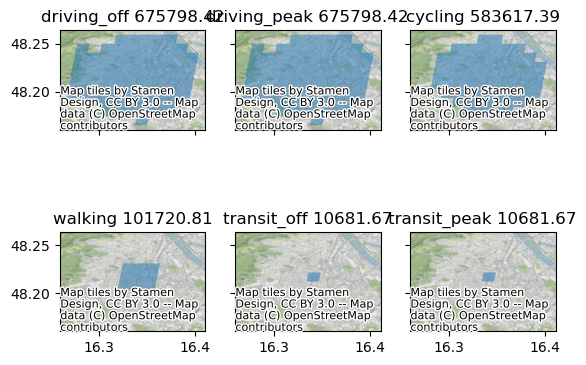

In [26]:
cell = isochrones[isochrones.pid == isochrones.sample(random_state=8).pid.iloc[0]].set_geometry('reach_geo')
cell = cell.sort_values('reach_km2', ascending=False)

fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True)
for i, trmode in enumerate(cell.trmode.unique()):
    ax = axs[i//3, i%3]
    ax.set_title(f'{trmode} {cell[cell.trmode==trmode].reach_pop.sum():.2f}')
    cell[cell.trmode == trmode].plot(ax=ax, alpha=0.5)
    ctx.add_basemap(ax=ax, crs="EPSG:4326")

cell

In [3]:
urbancenter_client = ExtractCenters(src_dir=os.path.join(DROOT, '2-external'), 
                                    target_dir=os.path.join(DROOT, '2-popmasks'))
pcl_path = urbancenter_client.extract_city(city.City, city.ID_HDC_G0, buffer=15000)
pop = gpd.GeoDataFrame(pd.read_pickle(pcl_path))
pop = pop.rename(columns={'geometry': 'raster'}).set_geometry('raster').set_crs(pop.crs)
pop['raster_km2'] = pop.raster.area
pop = pop.to_crs(isochrones.crs)

## Display reach of 9 sample elements
Expressed as population density on the map.

3it [00:28,  9.53s/it]


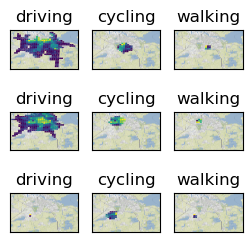

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(3,3), sharex=True, sharey=True)
samples = isochrones.pid.sample(3)
for y, pid in tqdm(enumerate(samples)):
    for x, mode in enumerate(['driving', 'cycling', 'walking']):
        sample = isochrones[(isochrones.pid == pid) & (isochrones['mode'] == mode)].iloc[0:1]
        ax = axs[y, x]
        sample.set_geometry('isochrone').plot(ax=ax)
        pop[pop.intersects(sample.iloc[0].isochrone)].plot(column='cell_pop', ax=ax)
        ax.set_title(sample.iloc[0]['mode'])
        ax.set_xticks([])
        ax.set_yticks([])
        ctx.add_basemap(ax=ax, crs=sample.crs, attribution="")

## Percentage of unary union of all modes reachable by that mode
Combines the total surface of that PID into one polygon, and calculates part reachable by mode

In [34]:
reach_km2 = isochrones[(isochrones.tt_mnts == 15)]
geometry_ua = reach_km2.groupby('pid').apply(lambda x: x.set_geometry('reach_geo').unary_union).rename('geometry_ua')

reach_km2 = reach_km2.merge(geometry_ua, on='pid').set_geometry('geometry_ua').set_crs('EPSG:4326')
reach_km2['reach_ua_perc'] = reach_km2.reach_km2 / reach_km2.set_geometry('geometry_ua').to_crs(reach_km2.estimate_utm_crs()).area
reach_km2.head(2)

,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,source,city_id,isochrone,cell_pop,raster,reach_n,reach_km2,reach_pop,reach_geo,geometry_ua,reach_ua_perc
0,2167-0-driving-15m-b,0,POINT (4.78390 52.51746),15,driving,driving,2023-06-13 08:30:00+02:00,b,2167,"POLYGON ((4.62613 52.48624, 4.63128 52.48784, ...",2276.701416,"POLYGON ((351000.000 6135000.000, 351000.000 6...",447.0,447000000.0,627009.495065,POLYGON ((4.6348287322705035 52.42493220326197...,"POLYGON ((4.63548 52.43467, 4.63612 52.44441, ...",0.998705
1,2167-0-cycling-15m-g,0,POINT (4.78390 52.51746),15,cycling,cycling,2023-06-13 08:30:00+02:00,g,2167,"POLYGON ((4.77698 52.51527, 4.77646 52.51031, ...",2276.701416,"POLYGON ((351000.000 6135000.000, 351000.000 6...",38.0,38000000.0,50474.159175,"POLYGON ((4.761149862643516 52.48336379128108,...","POLYGON ((4.63548 52.43467, 4.63612 52.44441, ...",0.084901


In [53]:
reach_km2_pivot = reach_km2.pivot_table(index=['city_id', 'pid'], columns=['mode'], values='reach_ua_perc')
reach_km2_pivot = reach_km2_pivot.merge(isochrones[['pid', 'raster']].drop_duplicates(), on='pid')
reach_km2_pivot = reach_km2_pivot.set_geometry('raster')
reach_km2_pivot.sort_values('cycling', ascending=False)

errors = reach_km2_pivot.driving < 0.8
reach_km2_pivot = reach_km2_pivot[~errors]
print('errors: ', errors.sum())

reach_km2_pivot

errors:  41


,pid,cycling,driving,walking,raster
0,0,0.084901,0.998705,0.013405,"POLYGON ((351000.000 6135000.000, 351000.000 6..."
1,1,0.125276,0.998727,0.024359,"POLYGON ((349000.000 6134000.000, 349000.000 6..."
2,10,0.152541,0.998714,0.025903,"POLYGON ((349000.000 6132000.000, 349000.000 6..."
3,100,0.077999,0.998727,0.015261,"POLYGON ((353000.000 6122000.000, 353000.000 6..."
6,103,0.091169,0.998714,0.014504,"POLYGON ((356000.000 6122000.000, 356000.000 6..."
...,...,...,...,...,...
340,95,0.112633,0.998675,0.022527,"POLYGON ((364000.000 6123000.000, 364000.000 6..."
341,96,0.092233,0.998753,0.018447,"POLYGON ((349000.000 6122000.000, 349000.000 6..."
342,97,0.037152,0.998744,0.013113,"POLYGON ((350000.000 6122000.000, 350000.000 6..."
343,98,0.082032,0.998735,0.016406,"POLYGON ((351000.000 6122000.000, 351000.000 6..."


3it [00:04,  1.45s/it]


Text(0.5, 0.98, 'Reachability % from cell centroid using mode')

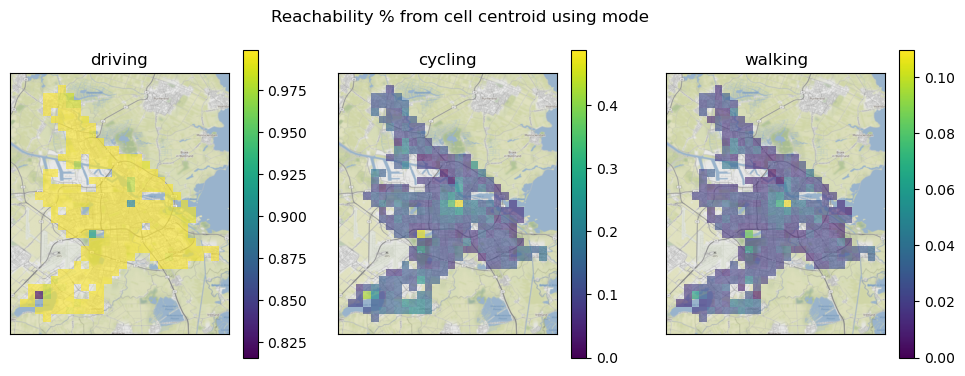

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)
for x, mode in tqdm(enumerate(['driving', 'cycling', 'walking'])):
    ax = axs[x]
    reach_km2_pivot.plot(column=mode, legend=True, alpha=0.6, ax=ax)
    # reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
    ax.set_title(mode)
    ax.set_xticks([])
    ax.set_yticks([])
    ctx.add_basemap(ax=ax, crs=reach_km2_pivot.crs, attribution='')
fig.suptitle("Reachability % of total options from cell centroid using mode (within 15 minutes)")

In [35]:
reach_pop = isochrones[(isochrones.tt_mnts == 15)]
reach_pop = reach_pop.pivot_table(index=['pid'], columns=['mode'], values='reach_pop')
reach_pop = reach_pop.drop_duplicates()
reach_pop = gpd.GeoDataFrame(reach_pop.merge(isochrones[['pid', 'raster']].drop_duplicates(), on='pid'), geometry='raster')
reach_pop = reach_pop.sort_index()
reach_pop.head(5)

KeyError: 'reach_ua_perc'

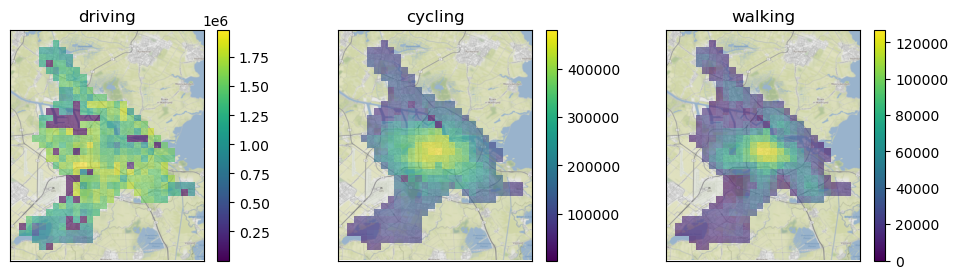

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3), sharex=True, sharey=True)
for x, mode in enumerate(['driving', 'cycling', 'walking']):
    ax = axs[x]
    reach_pop.plot(column=mode, legend=True, alpha=0.6, ax=ax)
    # reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
    ax.set_title(mode)
    ax.set_xticks([])
    ax.set_yticks([])
    ctx.add_basemap(ax=ax, crs=reach_pop.crs, attribution='')

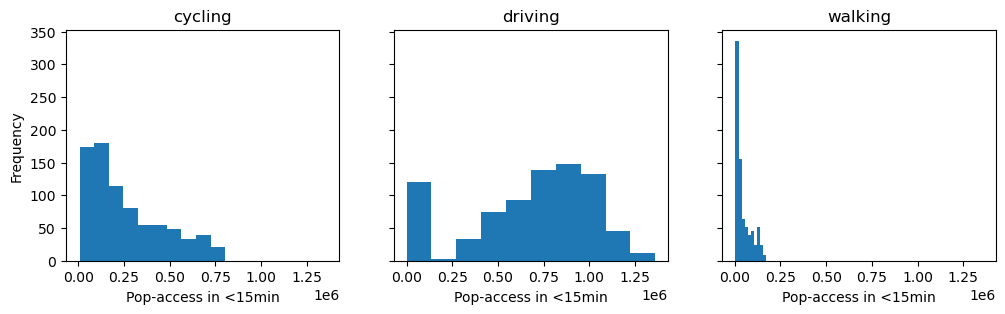

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3), sharex=True, sharey=True)
for i, mode in enumerate(['cycling', 'driving', 'walking']):
    reach_pop[mode].plot.hist(ax=axs[i])
    axs[i].set_title(mode)
    axs[i].set_xlabel("Pop-access in <15min")

In [ ]:
reach_pop['cycling_driving'] = reach_pop['cycling'] / reach_pop['driving']
reach_pop = reach_pop.sort_values('cycling_driving')
reach_pop

,pid,cycling,driving,walking,raster,cycling_driving
135,22,6661.434570,730517.892723,6661.434570,"POLYGON ((331000.000 5969000.000, 331000.000 5...",0.009119
57,15,29202.095829,640376.380495,4674.404453,"POLYGON ((335000.000 5970000.000, 335000.000 5...",0.045601
166,248,30434.874451,543790.366563,4275.218811,"POLYGON ((323000.000 5955000.000, 323000.000 5...",0.055968
4,101,43383.899549,647870.908039,4884.187378,"POLYGON ((338000.000 5965000.000, 338000.000 5...",0.066964
204,43,50693.699791,723334.838614,5965.046471,"POLYGON ((319000.000 5967000.000, 319000.000 5...",0.070083
...,...,...,...,...,...,...
220,58,87832.080719,1044.918579,11003.356689,"POLYGON ((334000.000 5967000.000, 334000.000 5...",84.056387
240,76,157719.299377,1574.396606,15260.313965,"POLYGON ((333000.000 5966000.000, 333000.000 5...",100.177616
227,64,192947.483467,1557.258301,11556.857544,"POLYGON ((321000.000 5966000.000, 321000.000 5...",123.902042
156,239,129774.985596,573.580811,13996.105286,"POLYGON ((324000.000 5956000.000, 324000.000 5...",226.254057


Text(0.5, 1.05, '(higher: cycling higher access)')

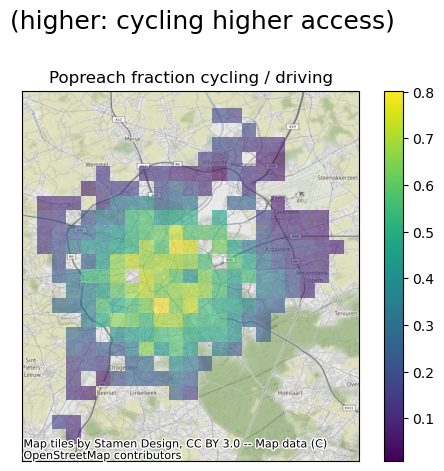

In [ ]:
fig, ax = plt.subplots()
reach_pop[reach_pop.cycling_driving < 3].plot(
    column='cycling_driving', legend=True, alpha=0.6, ax=ax)
# reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
ctx.add_basemap(ax=ax, crs=reach_pop.crs)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Popreach fraction cycling / driving')
fig.suptitle('(higher: cycling higher access)', y=1.05, fontsize=18)

,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,isochrone
400,3027-80-driving-25m-v0,80,POINT (16.30891 48.24531),25,driving,driving,2023-06-13 08:30:37+02:00,"POLYGON ((592670.384 5347989.466, 592167.602 5..."
401,3027-80-transit-peak-25m-v0,80,POINT (16.30891 48.24531),25,transit,transit-peak,2023-06-13 08:30:37+02:00,"MULTIPOLYGON (((594862.100 5343779.312, 594872..."
402,3027-80-transit-25m-v0,80,POINT (16.30891 48.24531),25,transit,transit,2023-06-13 13:00:37+02:00,"MULTIPOLYGON (((594665.973 5343751.293, 594805..."
403,3027-80-cycling-25m-v0,80,POINT (16.30891 48.24531),25,cycling,cycling,2023-06-13 13:00:37+02:00,"POLYGON ((597422.695 5346727.831, 597543.251 5..."
404,3027-80-walking-25m-v0,80,POINT (16.30891 48.24531),25,walking,walking,2023-06-13 08:30:37+02:00,"POLYGON ((595895.976 5343877.405, 596001.131 5..."


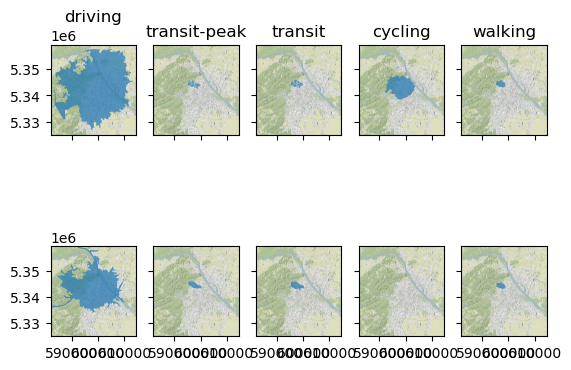

In [ ]:
sample = isochrones.set_geometry('isochrone')[isochrones.pid == 80]
sample_bing = isochrones_bing.set_geometry('isochrone')[isochrones_bing.pid == 80]

sample.isochrone = sample.isochrone.to_crs(sample.isochrone.estimate_utm_crs()).simplify(tolerance=50)
sample_bing.isochrone = sample_bing.isochrone.to_crs(sample_bing.isochrone.estimate_utm_crs()).simplify(tolerance=50)

fig, axs = plt.subplots(ncols=5, nrows=2, sharey=True, sharex=True)
for i, (rid, row) in enumerate(sample.iterrows()):
    gpd.GeoSeries([row.isochrone]).plot(alpha=0.7, ax=axs[0][i])
    ctx.add_basemap(ax=axs[0][i], crs=sample.crs, attribution='', zoom=14)
    axs[0][i].set_title(row.modetime)
    
for i, (rid, row) in enumerate(sample_bing.iterrows()):
    gpd.GeoSeries([row.isochrone]).plot(alpha=0.7, ax=axs[1][i])
    ctx.add_basemap(ax=axs[1][i], crs=sample.crs, attribution='', zoom=14)
sample

In [ ]:
# Analysis of reach during off-peak and on-peak times
offpeak = isochrones[(isochrones.modetime == 'transit') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area

onpeak  = isochrones[(isochrones.modetime == 'transit-peak') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area
bins = np.linspace(0, 8e6, 17)
plt.hist([offpeak, onpeak], bins, label=['off', 'on'], )

In [ ]:
w = isochrones
w['area'] = isochrones.to_crs(isochrones.estimate_utm_crs()).area
wew = w.groupby('pid').area.sum()

ax = w[w.pid.isin(list(wew[wew < 100].index))].set_geometry('startpt').plot()
ctx.add_basemap(ax, crs=w.crs)

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'stockholm-{t}', t, STARTDATE, 'driving')
    stockholm.plot(ax=axs[i])
    ctx.add_basemap(axs[i], crs="EPSG:4326")